In [17]:
import numpy as np
import pandas as pd
import datetime as dt
import xarray as xr
import rioxarray
import os

Grid point max ERM:
29.8


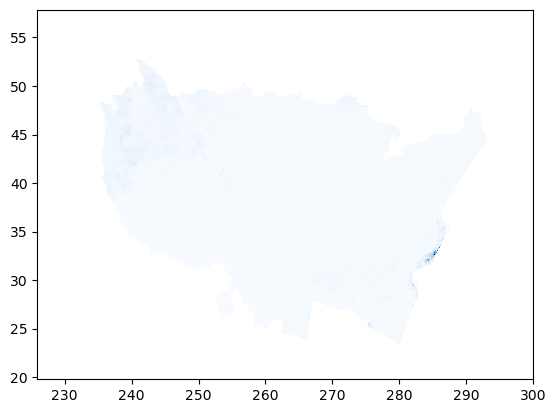

In [18]:
# Calculate rainfall accumuation: Stage IV analysis
data_dir = '/home/orca/bkerns/projects/doe_coastal/extreme_rain/global_gridded_erm/data/processed/erm_by_year'
date_start = dt.datetime(2025, 12, 1)
date_end = dt.datetime(2025, 12, 20)
date_list = pd.date_range(start=date_start, end=date_end, freq='24h')

# Get lat/lon from one historical data file.
fn = os.path.join(
    '/home/orca/data/in_situ/NCEP_stageIV_QPE/2025/daily',
    'st4_conus.2025010112.24h.nc')

with xr.open_dataset(fn) as ds:
    lats = ds['latitude'].data
    lons = ds['longitude'].data

fn = os.path.join(
    '/home/orca/data/in_situ/NCEP_stageIV_QPE/rt',
    'nws_precip_1day_20251201_conus.nc')

with xr.open_dataset(fn) as ds:
    x_orig = ds['x'].data
    y_orig = ds['y'].data

fn1 = os.path.join(
    data_dir,
    'precip_and_erm_3day.s4.2006_2020.2025.nc'
)

with xr.open_dataset(fn1) as ds:

    ds1 = ds.sel(time=slice(date_start, date_end))
    lons = ds1['lon'].data
    lats = ds1['lat'].data

    max_erm = ds1['daily_3day_erm'].max(dim='time').values

    print(f'Grid point max ERM:')
    print(np.nanmax(max_erm))

plt.pcolormesh(lons, lats, max_erm, cmap='Blues')

In [19]:

# Create xarray dataset with erm, lon, and lat
max_erm_ds = xr.Dataset(
    data_vars={
        'max_erm': (['y', 'x'], max_erm)
    },
    coords={
        'y': (['y',], y_orig[::-1]),
        'x': (['x',], x_orig)
    }
)

max_erm_ds['max_erm'].attrs["units"] = "1"
max_erm_ds['max_erm'].attrs["long_name"] = "Maximum ERM"
max_erm_ds['max_erm'].rio.write_nodata(0, inplace=True)

# Export to GeoTIFF
# Manually encode native HRAP projection.
hrap_crs = (
    "+proj=stere "
    "+lat_0=90 "
    "+lat_ts=60 "
    "+lon_0=-105 "
    "+a=6371200 "
    "+b=6371200 "
    "+units=m "
    "+no_defs"
)

max_erm_ds = max_erm_ds.rio.set_spatial_dims(x_dim="x", y_dim="y")
max_erm_ds = max_erm_ds.rio.write_crs(hrap_crs)

print(max_erm_ds)
print(max_erm_ds.rio.crs)
print(max_erm_ds.rio.transform())

max_erm_ds.rio.to_raster(
    "max_erm_4km.tif",
    driver="COG",
    compress="DEFLATE",
    dtype="float32",
    nodata=-9999
)


<xarray.Dataset> Size: 4MB
Dimensions:      (y: 881, x: 1121)
Coordinates:
  * y            (y) float64 7kB -7.617e+06 -7.612e+06 ... -3.431e+06 -3.426e+06
  * x            (x) float64 9kB -1.903e+06 -1.898e+06 ... 3.427e+06 3.431e+06
    spatial_ref  int64 8B 0
Data variables:
    max_erm      (y, x) float32 4MB nan nan nan nan nan ... nan nan nan nan nan
PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371200,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-105],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]
| 4762.50, 0.00,-1904912.11|
| 0.00, 4762.50,-7619546.20|
| 0.00, 0.00, 1.00|


In [20]:
# Stage on AWS S3
import boto3
s3 = boto3.resource('s3')
bucket='gaia-hazlab-map-data'
s3.Bucket(bucket).upload_file("./max_erm_4km.tif", "max_erm_4km.tif")

[autoreload of numpy._core._add_newdocs failed: Traceback (most recent call last):
  File "/home/disk/orca/bkerns/miniconda3/envs/gaia-hazlab-catalog/lib/python3.14/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/disk/orca/bkerns/miniconda3/envs/gaia-hazlab-catalog/lib/python3.14/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
  File "/home/disk/orca/bkerns/miniconda3/envs/gaia-hazlab-catalog/lib/python3.14/importlib/__init__.py", line 129, in reload
    _bootstrap._exec(spec, module)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 869, in _exec
  File "<frozen importlib._bootstrap_external>", line 759, in exec_module
  File "<frozen importlib._bootstrap>", line 491, in _call_with_frames_removed
  File "/home/disk/orca/bkerns/miniconda3/envs/gaia-hazlab-catalog/lib/python3.14/sit